# Imports

In [20]:
# for data analysis
import numpy as np
import pandas as pd

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for outlier capping
from scipy.stats.mstats import winsorize
import scipy.stats as stats  # Import statistical functions - used for Chi-Square

# for text pattern matching
import re

# for preprocessing
from sklearn.model_selection import train_test_split # For splitting the data into training/validation/test sets
from sklearn.pipeline import Pipeline # To create a sequential workflow of preprocessing steps
from sklearn.compose import ColumnTransformer # For applying different transformations to different columns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler # To encode categorical variables and scale numeric features

# for k-means clustering
from sklearn.cluster import KMeans   # K-Means clustering algorithm
from sklearn.metrics import silhouette_score  # For evaluating cluster quality
from sklearn.decomposition import PCA # To reduce dimensionality for visualization

# for Hierarchical clustering
import scipy.cluster.hierarchy as sch  # Provides functions for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering # Import AgglomerativeClustering for hierarchical clustering

## Data

In [2]:
cost_of_living = pd.read_csv("C:/Users/barbe/OneDrive/DS Projects/Cost of Living Prediction/cost_of_living_us.csv")

# Cleaning the Dataset

In [3]:
# Drop missing values
cost_of_living = cost_of_living.dropna(subset=['median_family_income'])

# Convert all object columns to category
for col in cost_of_living.select_dtypes(include=['object']).columns:
    cost_of_living[col] = cost_of_living[col].astype('category')

# select numerical columns
num_cols = cost_of_living.select_dtypes(include=['number']).columns

#define function to identify outliers via IQR
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

#create dataframe to store outliers
outliers_df = pd.DataFrame()

#apply function to numerical variables
#iterate over variables
for var in num_cols:
    outliers = identify_outliers(cost_of_living, var)
    #concatenate outliers to outlier dataframe
    outliers_df = pd.concat([outliers_df, outliers])

#drop duplicate rows since some rows may be outliers in multiple columns
outliers_df = outliers_df.drop_duplicates()

# Define a function to cap outliers
def cap_outliers(data, column, lower_pct=0.05, upper_pct=0.95):
    data[column] = winsorize(data[column], limits=(lower_pct, 1-upper_pct))
    return data

# Apply the function to all numerical columns
for var in num_cols:
    col_clean = cap_outliers(cost_of_living, var)

# Function to extract parent and child counts
def extract_family_counts(family_str):
    if isinstance(family_str, str):  # Ensure the input is a string
        match = re.match(r'(\d+)p(\d+)c', family_str)  # Regex to extract numbers before 'p' and 'c'
        if match:
            num_parents = int(match.group(1))  # Extract parent count
            num_children = int(match.group(2))  # Extract child count
        else:
            num_parents, num_children = 0, 0  # Default for unexpected formats
    else:
        num_parents, num_children = 0, 0  # Handle non-string cases safely

    return num_parents, num_children

# Ensure 'family_member_count' is a string before applying the function
col_clean['family_member_count'] = col_clean['family_member_count'].astype(str)

# Apply function to create new columns
col_clean[['num_parents', 'num_children']] = col_clean['family_member_count'].apply(lambda x: pd.Series(extract_family_counts(x)))

# Create total family size column
col_clean['family_total'] = col_clean['num_parents'] + col_clean['num_children']

# Drop case_id and family_member_count columns
col_clean = col_clean.drop(columns=['case_id', 'family_member_count'])

# Master Preprocessing

## Feature Redundancy Removal

In [4]:
# List of features to drop
features_to_drop = ["county", "areaname", "num_children", "num_parents"]

# Remove unnecessary columns from the dataset
col_clean = col_clean.drop(columns=features_to_drop)

## Handling Skewed Numerical Features

In [5]:
# Apply natural log transformation to right-skewed features
skewed_features = ["housing_cost", "taxes", "median_family_income"]
for feature in skewed_features:
    col_clean[feature + "_log"] = np.log1p(col_clean[feature])  # log(1 + x) to handle zero values safely

# Drop the original skewed columns to avoid redundancy
col_clean = col_clean.drop(columns=skewed_features)

## Handling Boolean Features

In [6]:
# Convert boolean to binary (0/1)
col_clean["isMetro"] = col_clean["isMetro"].astype(int)

# Save the result as the “master” cleaned dataset
master_df = col_clean.copy()

# Clustering Model Preprocessing

In [7]:
# Create a separate copy of master_df for the clustering pipeline
df_clust = master_df.copy() # df_clust will be used for clustering-specific preprocessing and analysis

# Drop the target variable 'total_cost' from the clustering DataFrame
df_clust = df_clust.drop(columns=["total_cost"])

In [8]:
def map_state_to_region(state):
    """
    Map a US state abbreviation (or 'DC') to one of the four US Census regions.
    
    Regions defined as:
    - Northeast: CT, ME, MA, NH, RI, VT, NJ, NY, PA
    - Midwest: IL, IN, MI, OH, WI, IA, KS, MN, MO, NE, ND, SD
    - South: DE, DC, FL, GA, MD, NC, SC, VA, WV, AL, KY, MS, TN, AR, LA, OK, TX
    - West: AK, AZ, CA, CO, HI, ID, MT, NV, NM, OR, UT, WA, WY
    """
    
    # Northeast
    if state in ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']:
        return 'Northeast'
    # Midwest
    elif state in ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']:
        return 'Midwest'
    # South (includes the District of Columbia, plus states from both the South Atlantic, East South Central, and West South Central)
    elif state in ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV',
                   'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX']:
        return 'South'
    # West
    elif state in ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']:
        return 'West'
    # If for some reason a state is not matched, return 'Other'
    else:
        return 'Other'

In [9]:
# Apply the mapping function to create a new 'region' column in df_clust
df_clust["region"] = df_clust["state"].apply(map_state_to_region)

# Drop the state column
df_clust = df_clust.drop(columns=["state"])

In [10]:
# For clustering, we will encode the 'region' column as our categorical feature.
categorical_feats_clust = ["region"]

# Identify numeric features: we grab all numeric columns from df_clust.
# This typically includes cost features, family totals, isMetro (already converted to 0/1), etc.
numeric_feats_clust = [col for col in df_clust.select_dtypes(include=["number"]).columns]

In [11]:
# Build a ColumnTransformer for clustering:
cluster_preprocessor = ColumnTransformer(
    transformers=[
        # OneHot encode the 'region' feature. Here we do not drop a category since in clustering,
        # having all encoded features is typically acceptable.
        ("region_ohe", OneHotEncoder(), categorical_feats_clust),
        # Normalize the numeric features to the [0, 1] range using MinMaxScaler.
        ("num_minmax", MinMaxScaler(), numeric_feats_clust)
    ],
    remainder="drop"  # Drop any columns not explicitly listed (ensures clean transformation)
)

In [12]:
# Wrap the ColumnTransformer into a Pipeline.
clust_pipeline = Pipeline(steps=[
    ("clust_preprocessing", cluster_preprocessor)  # Our pipeline currently consists of just the column transformer.
])

In [13]:
# Fit the clustering pipeline on the complete DataFrame and transform the data.
X_cluster = clust_pipeline.fit_transform(df_clust)

# Print the shape of the transformed dataset to verify that the transformation was successful.
print("Shape of the clustering-preprocessed dataset:", X_cluster.shape)

Shape of the clustering-preprocessed dataset: (31420, 14)


# Clustering

## Model Selection

Here are the clustering models we'll be considering:

**K-Means Clustering**:
- The dataset is comprised of continuous cost-related features (food cost, other necessities cost, taxes, family_total, childcare_cost, etc.) that have been scaled. K-Means performs best when features are continuous and measured on a similar scale since it minimizes Euclidean distances.
- K-Means is straightforward to understand and implement—it partitions data based on the distance to cluster centroids.
- It’s computationally efficient, an important consideration if you’re dealing with a moderate-to-large number of households.
- The cluster centroids provide a clear summary—the “typical” cost profile of each segment.
- Actionable Insights through Grouping: Since our regression models highlighted that key cost components (especially food and other necessities) drive household spending, K-Means will help us determine if households naturally group around these features. The centroids may highlight distinct spending patterns and allow us to label segments as high, moderate, or low spenders—establishing a clear segmentation that can be used for targeted interventions or further analysis.

**Hierarchical Clustering**
- Hierarchical clustering builds a dendrogram—a tree-like diagram—that shows how each observation is merged at various levels. Instead of forcing a pre-defined number of clusters, you can visually inspect the dendrogram and choose where to “cut” based on the data’s structure.
- Nested Groupings: Hierarchical clustering can expose a nesting of clusters.
- Granularity: This approach might reveal sub-clusters that wouldn’t be as easily detected by K-Means, providing additional nuance for understanding consumer behavior.
- Intuitive Visualization: The dendrogram output is a powerful visual tool. It lets us see not only how similar households are overall, but also which spending behaviors tend to cluster together.
- Robustness for a Moderate Size Dataset: Hierarchical clustering can be computationally heavier than K-Means, but for a dataset of moderate size (as is common in many expenditure studies), it is entirely feasible. It provides a complementary, more exploratory view that informs whether the clusters suggested by K-Means are robust or if there’s additional structure worth exploring.

## K-Means Clustering

K = 2, Inertia: 39745.51, Silhouette Score: 0.199
K = 3, Inertia: 32539.11, Silhouette Score: 0.224
K = 4, Inertia: 27153.91, Silhouette Score: 0.270
K = 5, Inertia: 23738.15, Silhouette Score: 0.268
K = 6, Inertia: 20497.57, Silhouette Score: 0.299
K = 7, Inertia: 18504.45, Silhouette Score: 0.297
K = 8, Inertia: 16799.74, Silhouette Score: 0.309
K = 9, Inertia: 14619.73, Silhouette Score: 0.332
K = 10, Inertia: 13913.24, Silhouette Score: 0.335


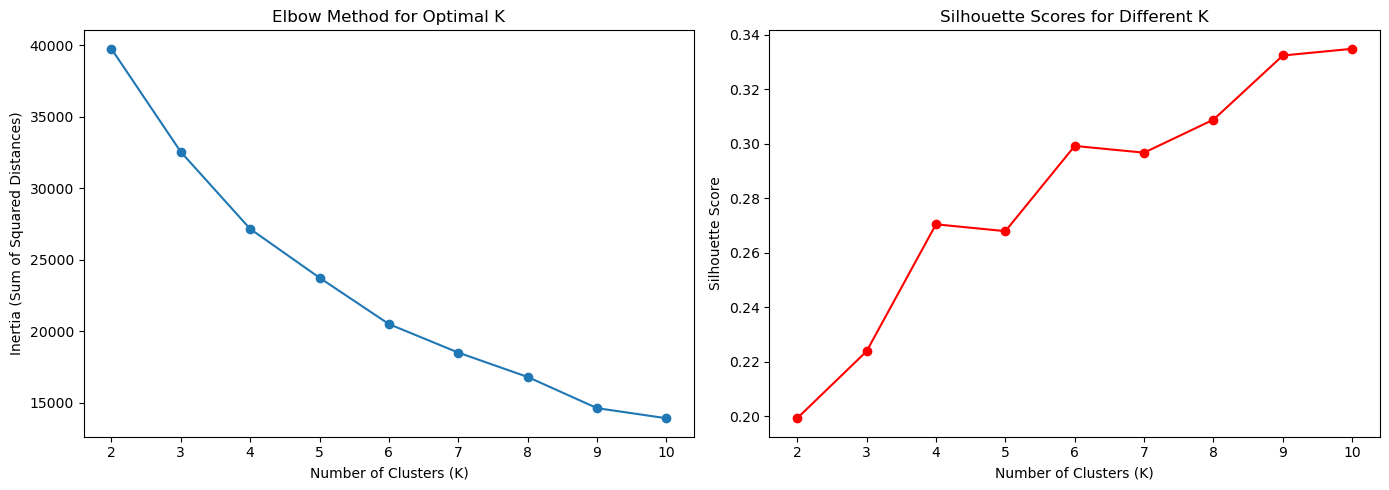

In [14]:
# Define a range of cluster numbers to test
K_range = range(2, 11)  # Testing cluster counts from 2 to 10

# Initialize empty lists to store the inertia (SSE) and silhouette scores for each K
inertias = []            # List to record inertia (sum of squared distances)
silhouette_scores = []   # List to record silhouette scores for each K

# Loop over the range of K values
for k in K_range:
    # Initialize the KMeans model with the given number of clusters and fixed random state
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit KMeans on the clustering-preprocessed data (X_cluster) and predict cluster labels
    cluster_labels = kmeans.fit_predict(X_cluster)
    
    # Append the inertia value (sum of squared distances) for this clustering
    inertias.append(kmeans.inertia_)
    
    # Calculate the silhouette score for the current clustering
    score = silhouette_score(X_cluster, cluster_labels)
    silhouette_scores.append(score)
    
    # Print the results for this value of K
    print(f"K = {k}, Inertia: {kmeans.inertia_:.2f}, Silhouette Score: {score:.3f}")

# Plot the Elbow curve (inertia vs. K) and the Silhouette Scores to find the best K
plt.figure(figsize=(14, 5))

# Subplot 1: Elbow Method plot
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")

# Subplot 2: Silhouette Score plot
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o', color='red', linestyle='-')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different K")
plt.tight_layout()
plt.show()

**Inertia Trend:**  
Inertia decreases steadily as K increases—from 39,745 at K=2 to 13,913 at K=10. However, the steep drop happens early on, and the benefit of adding extra clusters diminishes after about K=4–6.

**Silhouette Scores:**  
The silhouette score rises from 0.199 at K=2 to 0.335 at K=10. The improvement is most notable between K=2 and K=6 (0.270 at K=4 and 0.299 at K=6), with only marginal gains afterward.

**Balancing Act:**  
While a higher K (like 9 or 10) yields the best statistical separation, it may result in over-segmentation that is too granular for practical interpretation—especially in a cost-analysis context where simplicity is key.

**Cluster Choice:**  
Given the diminishing returns beyond K=4–6 and the need for actionable insights, choosing between 4 to 6 clusters strikes a balance. 
- Here, we'll choose K = 6 clusters. Note that K=6 offers a solid silhouette score (≈0.299) and maintains manageable, meaningful segments of household spending behaviors. This choice is practical for targeting interventions or understanding cost drivers without over-complicating the segmentation.

In [15]:
# Set the optimal number of clusters to 6
best_k = 6  # Using K = 6 as determined from our exploration

# Initialize the final K-Means model with 6 clusters and a fixed random state for reproducibility
final_kmeans = KMeans(n_clusters=best_k, random_state=42)

# Fit the model and predict cluster labels on the preprocessed clustering data
clusters_kmeans = final_kmeans.fit_predict(X_cluster)

# Add the computed cluster labels to the clustering DataFrame for further analysis
df_clust['KMeans_Cluster'] = clusters_kmeans

# Print counts of observations in each cluster to examine segmentation sizes
print("Cluster counts using K-Means with K = 6:")
print(df_clust['KMeans_Cluster'].value_counts())

Cluster counts using K-Means with K = 6:
0    7314
1    6913
3    5806
4    4803
2    4473
5    2111
Name: KMeans_Cluster, dtype: int64


**Analysis**
- Clusters 0 and 1 are the largest groups, with over 6,900 observations each. Clusters 2, 3, and 4 are moderately sized (between ~4,500 and ~5,800 observations). This spread indicates that K-Means found several groups with a substantial number of observations, suggesting that there are meaningful distinctions in spending patterns across these segments.
- Cluster 5 is notably smaller with 2,111 observations, which might indicate it represents a niche or distinct group. This could be a cluster that captures outlier behavior or a specific subset of households with unique characteristics (for example, households with particularly unusual spending patterns).
- The differences in cluster size can guide further investigation. For instance, we may want to profile each cluster to understand what distinguishes them in terms of key variables (like food cost, other necessities, taxes, etc.). A smaller cluster might warrant a closer look to decide if it represents a target segment for specialized intervention or if it contains potential outliers.

In [16]:
# Calculate and display the mean values of each feature for every cluster
cluster_profiles = df_clust.groupby('KMeans_Cluster').mean(numeric_only=True)
print("Cluster Profiles (Mean Values):")

# Get additional descriptive statistics for each cluster
cluster_descriptions = df_clust.groupby('KMeans_Cluster').describe()
print("Cluster Descriptions:")
print(cluster_descriptions)

Cluster Profiles (Mean Values):
Cluster Descriptions:
               isMetro                                              food_cost  \
                 count      mean       std  min  25%  50%  75%  max     count   
KMeans_Cluster                                                                  
0               7314.0  0.502871  0.500026  0.0  0.0  1.0  1.0  1.0    7314.0   
1               6913.0  0.325908  0.468747  0.0  0.0  0.0  1.0  1.0    6913.0   
2               4473.0  0.321708  0.467184  0.0  0.0  0.0  1.0  1.0    4473.0   
3               5806.0  0.326042  0.468803  0.0  0.0  0.0  1.0  1.0    5806.0   
4               4803.0  0.234645  0.423821  0.0  0.0  0.0  0.0  1.0    4803.0   
5               2111.0  0.615822  0.486516  0.0  0.0  1.0  1.0  1.0    2111.0   

                              ... taxes_log            \
                        mean  ...       75%       max   
KMeans_Cluster                ...                       
0               10500.322598  ...  9.152980  

**Analysis**

1. Cluster Sizes and Overall Segmentation
- Clusters 0 (7,314) and 1 (6,913) are the largest, while Clusters 2 (4,473), 3 (5,806), and 4 (4,803) are moderately sized. Cluster 5 is smaller (2,111), suggesting it may capture a more niche or distinct segment.

2. Key Variables Driving Differences
- Metro Status: The mean values differ across clusters. For instance, Cluster 5 has a mean of ~0.616, indicating a higher proportion of metro households compared to Clusters 1 (0.326) or 4 (0.235). This variable helps differentiate urban versus rural spending patterns.

- Cost Components: While the output snippet doesn’t show full details for every cost component, differences in means for key expenses like food cost would indicate that some clusters have markedly different spending behavior. Clusters with higher average food or necessity costs could represent higher-spending households.

- Taxes (logged): There’s notable variability. For example, Cluster 0 shows a higher average tax value (10,500) compared to Clusters 1 (5,552) and 4 (5,233). This suggests that some clusters experience higher tax burdens, which might correlate with urban areas or higher expenditure levels.

- Median Family Income (logged): The mean logged income ranges from about 10.98 (Cluster 1) to 11.27 (Cluster 5), indicating moderate variation in economic status across clusters. Clusters with higher median income (e.g., Cluster 5) may align with higher spending categories or metro populations.

3. Interpretation and Actionability
- Large, Typical Segments (Clusters 0 and 1): Likely represent the bulk of households with “average” spending behavior across key cost components.

- Niche or Unique Segment (Cluster 5): With a higher metro proportion and higher family income, this group may represent an affluent, possibly urban segment with distinct spending patterns.

- Moderate Segments (Clusters 2, 3, and 4): These groups may differ in subtle ways (for example variations in taxes and primary cost drivers) that warrant further analysis, possibly revealing mid-tier spending patterns.

- Next Steps for Deeper Insights:  
  - Profile Each Cluster: Drill down into variables like food cost, other necessities, and secondary expenditures to understand what makes each cluster distinct.
  - Contextualize with Domain Knowledge: Compare these statistical differences with economic or regional factors (e.g., urban vs. rural trends, cost-of-living differences) that might explain why certain clusters have higher spending or tax values.
  - Actionable Insights: Use this segmentation to tailor strategies. For example, clusters with higher spending and higher median income might be targeted for premium financial services, whereas clusters with lower spending patterns might be ideal for cost-saving or budget-focused initiatives.

Summary
The profiling output shows that our K-Means segmentation into 6 clusters yields both large, typical segments and a smaller, distinct group (Cluster 5). Key variables—such as metro status, taxes, and family income—vary across clusters, offering a basis for actionable insights.

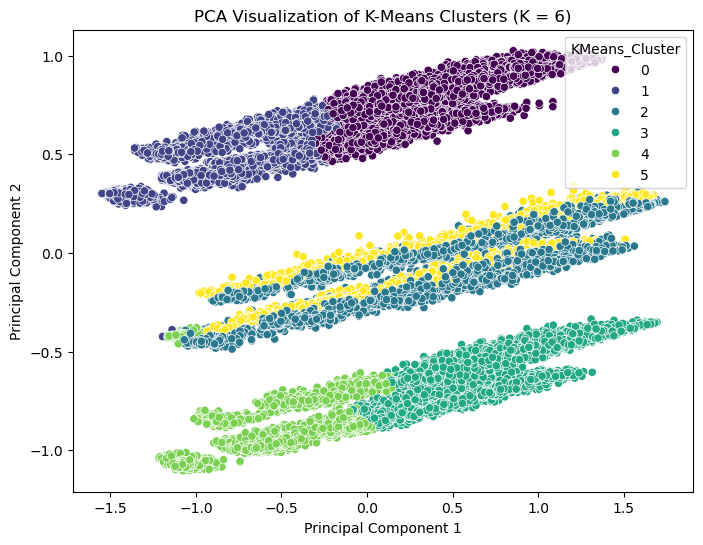

In [17]:
# Initialize PCA to reduce data to 2 principal components for visualization
pca_vis = PCA(n_components=2)
components = pca_vis.fit_transform(X_cluster)

# Create a scatter plot of the PCA-reduced data, color-coded by the K-Means clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=components[:, 0], y=components[:, 1],
                hue=df_clust['KMeans_Cluster'],
                palette="viridis", 
                legend='full')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of K-Means Clusters (K = 6)")
plt.show()

**Analysis**

The PCA scatter plot shows a clear separation of the six clusters in the two-dimensional space defined by the first two principal components.

- Distinct Cluster Separation: Each cluster is represented by a different color, and we can see that the clusters are mostly well-separated. This is an encouraging sign that the K-Means algorithm has found meaningful groupings in the data.

- Visual Density and Overlap: Some clusters appear tighter and more compact, which indicates that the observations in those clusters are very similar in the reduced dimension. While slight overlaps are natural when projecting higher-dimensional data into two dimensions, overall, the clusters maintain their distinct boundaries, suggesting that important differences in cost-related features (like food cost, other necessities, and taxes) are well captured.

- Interpretation Implications:
  - Actionable Segments: The distinct separation means we can be confident with our cluster profiling, knowing that each segment likely represents a unique consumer archetype.  
  - Cluster 5: Given that cluster 5 was smaller in the numerical output and appears clearly as a separate group, it likely represents a niche or distinctive subset of households (possibly with unique spending or demographic characteristics such as higher metro membership).  
  - Overall Structure: The fact that the first two principal components provide reasonable discrimination among the clusters suggests that these components capture a significant portion of the variance driven by the underlying key cost features.

### Conclusion

**1. Segmentation Overview**
The data split into six clusters suggests that household spending behaviors naturally group into distinct segments. While Clusters 0 and 1 are the largest, Clusters 2, 3, and 4 are moderate in size, and Cluster 5 is much smaller. This indicates that the model is picking up on both common spending profiles and a niche segment.


**2. Key Variables and Their Implications**
- Metro Status:  Cluster 5 stands out with the highest metro proportion (~ 0.62), suggesting that this group is predominantly composed of urban households. In contrast, Cluster 4 shows the lowest metro percentage (~ 0.23), indicating these households are likely from rural or suburban areas. Urban households may experience higher living costs and have access to different services compared to non-metro households. This variable is critical when targeting products or policies that might differ for urban versus rural segments.

- Median Family Income (Logged): The average logged family income increases from Clusters 1 (around 10.98) to Cluster 5 (about 11.27). Higher income in Cluster 5 aligns with its high metro representation, likely reflecting a segment with more disposable income and potentially higher overall spending. In contrast, clusters with lower median incomes may display more cost-sensitive behavior.

- Tax Environment: Differences in average taxes suggest that regional tax policies or local cost-of-living might be influencing spending profiles. Higher tax values may correlate with areas that have elevated overall expenses, or they might indicate regions with specific fiscal policies that affect household budgets differently.

- Cost Drivers: Although explicit cost averages for these variables aren’t shown in full here, previous regression results highlighted that these are your dominant drivers. It’s likely that clusters with higher spending or higher cost burdens on these components represent households that experience a significantly different cost structure. If one cluster consistently shows higher expenditure in food or other necessities, it could signal a higher cost-of-living segment or a group with larger households. This insight can drive strategies around consumer budgeting, targeted financial products, or regional cost-of-living adjustments.


**3. Interpreting the Clusters for Strategic Insights**
- Cluster 5: Has highest metro participation and the highest median family income. This likely represents affluent urban households with distinct spending patterns—possibly higher overall expenditures or a different mix of costs. This could be a target for premium services or urban-specific financial products.

- Clusters 0 and 1: These are the largest clusters, suggesting they capture a broad swath of typical spending behavior. They likely represent the “average” cost patterns in the dataset. Tailored interventions here should focus on broad-based cost management strategies, as they affect the largest number of households.

- Clusters 2, 3, and 4: These have moderate sizes and subtle variations in key variables like taxes and cost components. While they may not be as extreme in their spending, differences among them could reveal regional or lifestyle nuances. These clusters might benefit from more fine-tuned analysis—for instance, understanding whether one group is more sensitive to tax burdens or whether another correlates with distinct cost behaviors. Such distinctions can inform targeted policies or localized marketing efforts.

## Hierarchical Clustering

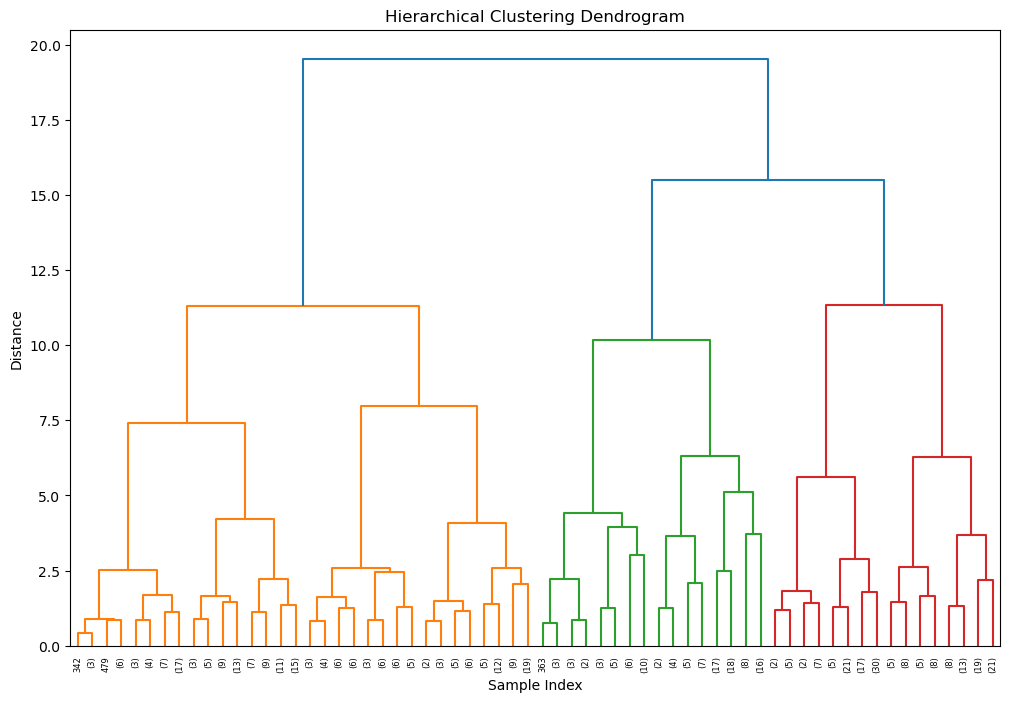

In [19]:
# Step 1: Randomly select a subset of data for visualization
# Since the full dataset is large, we'll sample 500 observations for a readable dendrogram
subset_idx = np.random.choice(X_cluster.shape[0], 500, replace=False)  # Randomly pick 500 indices without replacement
X_sample = X_cluster[subset_idx]  # Extract the corresponding subset from your clustering data

# Step 2: Compute the linkage matrix
# This matrix encodes the distance between clusters using Ward's method (minimizes variance within clusters)
linkage_matrix = sch.linkage(X_sample, method='ward')  # Ward's method is generally good for numerical, continuous data

# Step 3: Plot the dendrogram
plt.figure(figsize=(12, 8))  # Set the size of the figure for better readability

# Create the dendrogram with truncation to only show top levels (more interpretable)
# truncate_mode='level' cuts the dendrogram at a certain depth; p=5 shows the top 5 levels of merges
dend = sch.dendrogram(linkage_matrix, truncate_mode='level', p=5)

# Add title and axis labels for context
plt.title("Hierarchical Clustering Dendrogram")  # Main title
plt.xlabel("Sample Index")  # X-axis: arbitrary sample indices
plt.ylabel("Distance")      # Y-axis: linkage distance (the vertical height at which clusters merge)

# Display the dendrogram
plt.show()

The dendrogram shows a stepwise merging of clusters, with the height of the vertical lines representing the distance (or dissimilarity) between merged groups. The farther up a merge occurs, the more distinct the groups being combined.
- You can see several low-level merges (closer to the bottom), which suggests tight, closely related observations—great for cluster cohesion.
- The larger vertical jumps near the top signal possible cut-off points where significant cluster boundaries exist. This is where it’s most meaningful to draw a line and assign cluster labels.

Given the branching and the visible gap between the top 3–4 horizontal merge lines, cutting the dendrogram around that height would likely yield 5 to 6 clusters. This aligns nicely with our earlier K-Means choice of 6 and makes it a reasonable starting point for hierarchical clustering as well.
- Color-coded branches (orange, green, red) suggest where the algorithm would draw cluster divisions if we specify a number of clusters.
- These colored segments provide a quick visual of groupings. If we see a dense bundle of similar color lower in the dendrogram, that means the data points in that group are very cohesive.

In [22]:
# Initialize AgglomerativeClustering with 6 clusters and use the 'ward' linkage.
# When linkage='ward', Euclidean distance is inherently used.
hierarchical = AgglomerativeClustering(n_clusters=6, linkage='ward')

# Fit the model on the preprocessed data and predict cluster labels.
clusters_hier = hierarchical.fit_predict(X_cluster)

# Add the hierarchical cluster labels to the existing DataFrame for further analysis.
df_clust['Hierarchical_Cluster'] = clusters_hier

# Print the counts of observations in each hierarchical cluster as a sanity check.
print("Cluster counts using Hierarchical Clustering:")
print(df_clust['Hierarchical_Cluster'].value_counts())

Cluster counts using Hierarchical Clustering:
0    9030
2    6885
3    5190
1    4480
4    3665
5    2170
Name: Hierarchical_Cluster, dtype: int64


**Analysis**

Cluster Sizes: We can clearly see that the clusters are not evenly sized. This implies that some groups (like Cluster 0) capture a broader or more common pattern within your data, while others (like Cluster 5) may represent a more niche or unique segment.
- The total number of observations adds up to 31,420, which confirms that all data points are accounted for in the clusters.

While K-Means yielded clusters with sizes like 7,314 and 6,913, hierarchical clustering produces a different segmentation.
- The numbers (cluster labels) are arbitrary. The meaning lies in the characteristics of the groups, not in the specific label numbers (i.e., Cluster 0 in hierarchical clustering is not necessarily analogous to Cluster 0 in K-Means).
- Hierarchical clustering builds a nested structure from individual observations up to larger clusters, which might capture different aspects of our data’s structure compared to the centroid-based approach of K-Means.

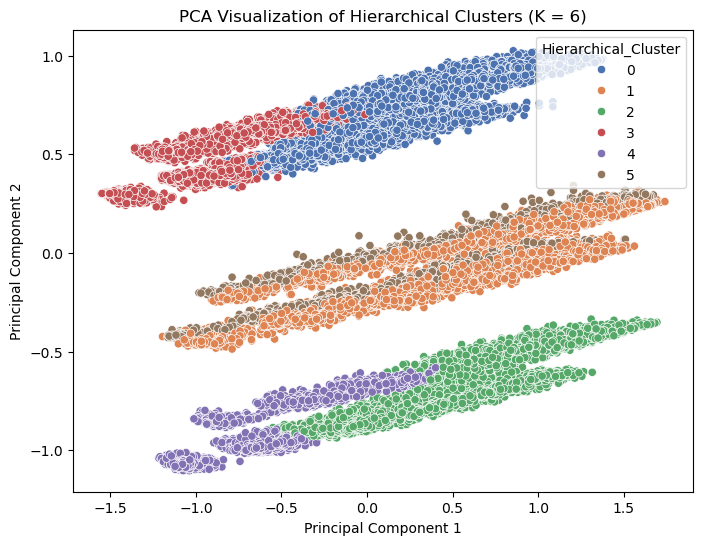

In [23]:
# Initialize PCA to reduce the dimensionality of the data to 2 components (for 2D visualization)
pca_vis = PCA(n_components=2)

# Fit the PCA model on the X_cluster data and transform the data into 2 principal components
components = pca_vis.fit_transform(X_cluster)

# Plot the hierarchical clusters in the PCA-reduced space
plt.figure(figsize=(8, 6)) # Create a new figure with a specified size (8 inches wide by 6 inches tall)

# Create a scatter plot using the first two principal components
sns.scatterplot(
    x=components[:, 0],                    # Set x-coordinate using the first principal component
    y=components[:, 1],                    # Set y-coordinate using the second principal component
    hue=df_clust['Hierarchical_Cluster'],  # Color-code points based on their hierarchical cluster label
    palette='deep',                        # Use the 'deep' palette for distinct colors
    legend='full'                          # Display a full legend mapping colors to cluster labels
)

plt.xlabel("Principal Component 1") # Add a label to the x-axis indicating it represents the first principal component
plt.ylabel("Principal Component 2") # Add a label to the y-axis indicating it represents the second principal component
plt.title("PCA Visualization of Hierarchical Clusters (K = 6)") # Set a title to indicate this is a PCA visualization of hierarchical clusters
plt.show() # Display the plot

The PCA visualization of our hierarchical clusters looks very similar to the one for K-Means, with only minor differences in how points are colored and grouped, because both methods are capturing very similar underlying structures in the data.
- Both clustering methods are revealing the same natural separations in the data. The fact that the PCA scatter plots look nearly identical suggests that the key variances in our data drive similar grouping regardless of the algorithm. This is a strong indicator that our segmentation is robust and not overly sensitive to the choice of clustering method.
- Although the process is different, the end result in PCA space is largely coherent: the distinctions between clusters remain clear and stable across both methods.
- The clusters are color-coded differently between the two plots, but that does not change their intrinsic properties. The clusters maintain similar positions and separations, reinforcing the idea that the segmentation (for instance, the 6-cluster structure) is a true reflection of the data rather than an artifact of one specific algorithm.
- Since both methods arrive at a similar segmentation, we can be more confident in using these clusters for further analysis.

In [24]:
# Group the DataFrame by the hierarchical cluster labels and calculate the mean for all numeric features
# 'numeric_only=True' ensures that only numeric columns are included in the mean calculation
hier_profile = df_clust.groupby('Hierarchical_Cluster').mean(numeric_only=True)

# Print the computed mean values for each feature within each hierarchical cluster to help interpret differences
print("Hierarchical Cluster Profiles (Mean Values):")
print(hier_profile)

Hierarchical Cluster Profiles (Mean Values):
                       isMetro    food_cost  transportation_cost  \
Hierarchical_Cluster                                               
0                     0.426246  9911.681754         14102.143176   
1                     0.321429  8839.345072         14211.677572   
2                     0.233987  9712.812317         14409.679593   
3                     0.400963  4943.788901         12153.841956   
4                     0.384447  4816.680105         12344.925127   
5                     0.599078  8952.124904         13381.549326   

                      healthcare_cost  other_necessities_cost  childcare_cost  \
Hierarchical_Cluster                                                            
0                        16172.596441             7837.906442    11134.429328   
1                        12659.942726             7832.141016    11494.603183   
2                        16120.955583             7533.274969    13389.217940   
3    

**Analysis**

Our hierarchical clustering has grouped households into six clusters. Although all clusters include households spending on similar cost categories (food, transportation, healthcare, childcare, etc.), the means reveal notable differences, suggesting distinct household profiles in terms of spending patterns and likely lifestyle or demographic characteristics.

Metro Status:
- Cluster 5: With an average isMetro of ~0.599, this group has the highest urban representation.
- Clusters 3 and 4: Lower averages (~0.401 and ~0.384, respectively) indicate a smaller percentage of urban households and possibly more suburban or rural settings.
- Implication: Cluster 5 households are likely concentrated in urban areas, possibly facing higher living costs, while lower metro representation in clusters 3 and 4 may indicate a rural or suburban demographic with different spending behaviors

Food Cost:
- Clusters 0, 2, and 1: Average food costs are relatively high (around 9800–9900 for Clusters 0 and 2, and slightly lower for Cluster 1 at ~8839).
- Clusters 3 and 4: Extremely lower food spending (around 4800–4944) suggests households that either have smaller households, lower discretionary food expenditures, or possibly a different overall cost structure.
- Implication: Higher food costs in some clusters may indicate larger families or higher cost-of-living scenarios, whereas the lower food spending in clusters 3 and 4 might correspond to smaller households (or households with lower consumption).

Transportation Cost:
- Clusters 0, 1, and 2: These clusters spend around 14,000+ on transportation, suggesting households that may be located in areas where commuting or travel is more expensive.
- Clusters 3 and 4: With transportation costs around 12,150 to 12,345, these groups incur comparatively lower transportation spending.
- Implication: Higher transportation costs could either be due to greater distances traveled (common in urban settings with high mobility) or reflect a higher cost of vehicle operation/public transit in particular regions.

Healthcare and Childcare Costs:
- Clusters 0 and 2: Healthcare spending is very high (near 16,170) in tandem with high childcare costs (11,134 and 13,389, respectively).
- Clusters 3 and 4: Both healthcare and childcare expenses are noticeably lower (healthcare around 8,715–8,785 and childcare around 3,443–3,786).
- Cluster 5: This cluster shows intermediate healthcare (~11,989) but high childcare (~12,909).
- Implication: The high expense in clusters 0 and 2 might indicate households with significant demands for healthcare (possibly older or with specific health needs) and larger families (reflected in higher childcare costs). In contrast, the low spending in clusters 3 and 4 might point to smaller households or those with a different age structure (perhaps fewer children or healthier profiles).

Family Total and Housing/Tax Costs:
- Family Total: Clusters 0 and 2 have family totals around 4.4, suggesting larger households, while clusters 3 and 4 are much lower (around 1.9), hinting at smaller households.
- Housing Cost (log) and Taxes (log): Clusters 3 and 4 also record lower values for both housing and taxes, which reinforces the idea that these groups might be located in lower cost-of-living areas compared to those with higher values.
- Implication: Household size (and potentially, composition) appears to be a key differentiator across clusters, with larger households (which may drive higher overall spending in categories like food and healthcare) standing apart from smaller households.

Median Family Income (logged):
- The logged incomes range from roughly 10.998 (Cluster 3) to 11.268 (Cluster 5), with Cluster 5 on the higher end.
- Implication: The modest differences in income suggest that while income is a differentiator, it may not be the primary driver of the segmentation. However, Cluster 5’s higher income coupled with a higher urban presence points to an affluent, metro-based segment that might be more sensitive to higher childcare and transportation costs.

Clusters 0 and 2: These segments have high food and healthcare costs along with relatively high family sizes (family_total ~4.4). They likely represent households with larger families and higher overall expenditures, perhaps in areas with a higher cost-of-living where expenses for essentials like healthcare are significant.

Cluster 1: Although it has a slightly lower food cost (~8839) and smaller family size (family_total ~3.5) compared to Clusters 0 and 2, its transportation and childcare costs remain high. This could indicate a segment of households that are moderate in size but have elevated travel and care needs.

Clusters 3 and 4: Characterized by low spending on food, childcare, and lower family totals (around 1.9), these clusters likely represent smaller households—perhaps single-person or couple households, or households with older individuals who do not have children. Their lower housing and tax costs further support the possibility they reside in lower cost areas.

Cluster 5: Stands out with the highest metro representation (isMetro ~0.599) and the highest median income (11.268). Its spending patterns (childcare cost ~12910 and transportation cost ~13382) suggest a busy, urban lifestyle where higher incomes support higher discretionary and essential spending. This segment likely represents affluent, metro-based families.